<a href="https://colab.research.google.com/github/kdmalc/intro-computer-vision/blob/main/HW4_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Kai Malcolm

NetID: km82

Collaborators: NA

## General instructions
Please copy this colab notebook into your own Drive to edit. This notebook will also serve as your final submission report - please ensure that code cells run correctly, and that all non-code (text/latex) blocks are rendered correctly before submissing the file. Feel free to add any additional cells (code or text) you need. Please follow good coding, markdown, and presentation etiquette.

__Please do not use any AI tools for this assignment.__


## Submission instructions

- Before submitting, please `run-all` the code. This will re-render your entire jupyter file cell by cell to produce all the outputs.

- You are required to download the colab notebook as a `.ipynb` file and submit it to canvas. Please name your `.ipynb` file as `netid.ipynb`

- Modify the text cell on top to include your name and the names of any collaborators from this class you worked with on this assignment.

- Download a pdf of the executed colab notebook. You can use print -> save as pdf. Please name your `.pdf` file as `netid.pdf`.

- Any extra images used in the homework should also be uploaded to canvas.

- For simplicity, you can also upload a `netid.zip` file to canvas containing all solution files.

In [3]:
import math
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torchvision import transforms as T

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Problem 1

### Problem 1.1: Basics of Autograd

In [4]:
"""
Taylor approximation to sin(x).
x: (Tensor[float]) input value(s)
n: (int) number of terms in Taylor approximation

Output:
(Tensor[float]) Taylor approximation to sin(x)
"""
def sin_taylor(x, n=10):
  # f(x) ~ \sum f^n(a)/(n!) * (x-a)^n
  # Let a = 0 (assuming we are evaluating at 0)
  # f(x) is just sin(x)
  # n is the number of terms to use in the approx
  result = 0
  for k in range(n):
      sign = 1 if k % 4 != 3 else -1
      if k%2==0:
          deriv = np.sin(0)
      else:
          deriv = np.cos(0)
      #print(f"k: {k}; sign: {sign}, deriv: {deriv}")
      term = sign * deriv / math.factorial(k) * (x ** k)
      result += term
  return result

In [5]:
print(sin_taylor(np.pi / 2, 10))  # Should be close to 1

1.0000035425842861


In [6]:
# 1b

x = torch.tensor(np.pi / 4, dtype=torch.float64, requires_grad=True)
y = sin_taylor(x, 10)
# Use autograd to compute dy/dx
y.backward()

# Compare to exact derivative: cos(π/4)
print("My taylor approx answer:", y.item())
print("Autograd answer:", x.grad.item())
print("Gruond truth:", np.cos(math.pi/4))


My taylor approx answer: 0.7071067829368671
Autograd answer: 0.7071068056832943
Gruond truth: 0.7071067811865476


In [7]:
# 1c

x_npy = np.random.uniform(-math.pi, math.pi, size=100)
x = torch.tensor(x_npy, dtype=torch.float32).to('cuda')
x.requires_grad_()
y = sin_taylor(x, 10)
z = y.sum().backward()

print("x.grad (calc dy/dx):\n", x.grad)
print()
print("Error: x.grad (calc dy/dx) VS ground truth (cosx):\n", x.grad - torch.cos(x))


x.grad (calc dy/dx):
 tensor([-0.8758, -0.9762, -0.9553, -0.9327, -0.5594, -0.9548,  0.6220,  0.2949,
        -0.9344,  0.3102, -0.8392, -0.3140,  0.9383, -0.9285,  0.5940, -0.8428,
        -0.7979, -0.9235,  0.2604, -0.5346, -0.5045, -0.4361,  0.2899,  0.8189,
         1.0000, -0.7638, -0.2085,  0.4144, -0.9482, -0.2928, -0.9640, -0.9272,
         0.1513, -0.3396, -0.7667,  0.6355, -0.9756, -0.6099, -0.1648,  0.8839,
        -0.9700,  0.6412, -0.8705, -0.3882, -0.6087, -0.9651,  0.1109,  0.8947,
        -0.7199, -0.6524, -0.0956, -0.9756,  0.6883, -0.9339, -0.8598,  0.9741,
        -0.4129,  0.8051, -0.4007,  0.2318,  0.9346,  0.5955,  0.7938,  0.5025,
        -0.8844, -0.4999,  0.6343, -0.1060,  0.9908,  0.1885, -0.2457,  0.9733,
        -0.2523,  0.1372,  0.6558,  0.9311,  0.0742, -0.0983, -0.9648,  0.8724,
         0.9246,  0.5670,  0.9163, -0.8782,  0.7546,  0.9324,  0.6160,  0.8299,
        -0.9753, -0.8775, -0.9780, -0.4713,  0.8873, -0.9734, -0.5813,  0.9899,
         1.0000,  

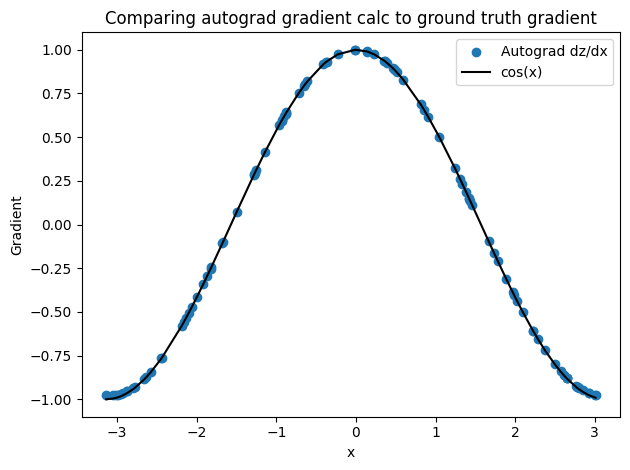

In [8]:
# 1d

# Using the same variables from 1c
dzdx = x.grad.cpu().numpy()

plt.figure()
plt.scatter(x_npy, dzdx, label="Autograd dz/dx")
plt.plot(np.sort(x_npy), np.cos(np.sort(x_npy)), label="cos(x)", color='black')
plt.xlabel("x")
plt.ylabel("Gradient")
plt.title("Comparing autograd gradient calc to ground truth gradient")
plt.legend()
plt.tight_layout()
plt.show()


### Problem 1.2: Image Denoising

In [9]:
"""
Returns the x and y gradient images for input image I.
Input:
I: (Tensor) Image of shape (H, W, 3)

Output:
(Ix, Iy): (Tensor) Gradient images each of shape (H, W, 3)
"""
def get_spatial_gradients(I):
  I = I.permute(2, 0, 1).unsqueeze(0) # Change I's shape from (H, W, 3) to (1, 3, H, W)
  kx = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)
  ky = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)

  for i in range(3):
    kx[i, i, 1, 1] = -1
    kx[i, i, 1, 2] = 1
    ky[i, i, 1, 1] = -1
    ky[i, i, 2, 1] = 1

  Ix = F.conv2d(I, kx, padding=1)
  Iy = F.conv2d(I, ky, padding=1)
  return Ix[0,...].permute(1,2,0), Iy[0,...].permute(1,2,0)

"""
Denoising objective function.
Input:
I, J: (Tensor) Images of shape (H, W, 3)
alpha: (float) Regularization hyperparameter

Output:
loss: (Tensor[float])
"""
def denoising_loss(I, J, alpha):
  dxJ, dyJ = get_spatial_gradients(J)
  return torch.norm(I-J, p=1) + alpha*( torch.norm(dxJ, p=1) + torch.norm(dyJ, p=1))

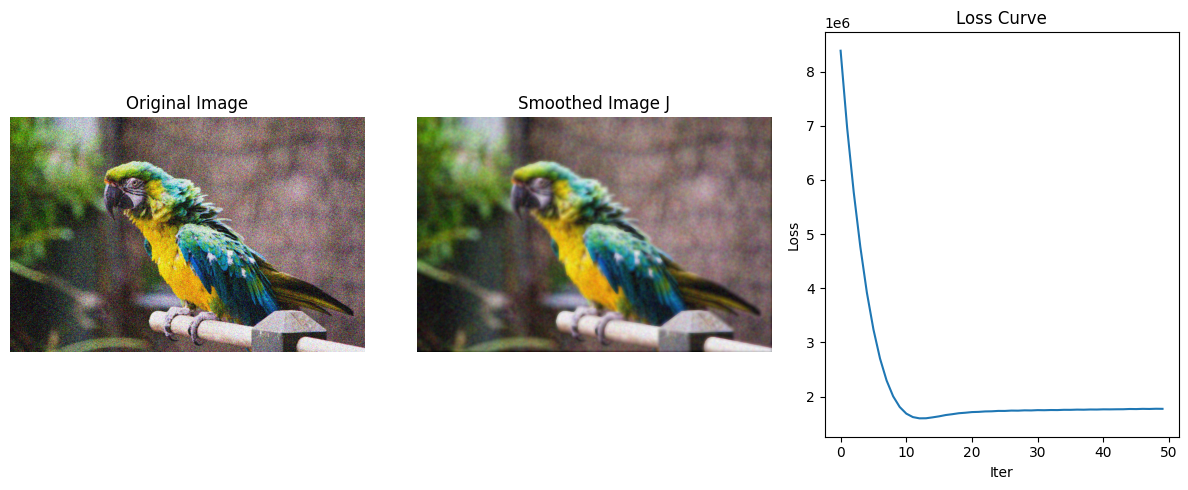

In [10]:
img = imageio.imread('/content/drive/My Drive/ELEC546/HW4/parrot_noisy.png') / 255.0
I = torch.tensor(img, dtype=torch.float32)
I = I.to('cuda')

lr = 0.001 # Learning rate
alpha = 10.0 # alpha
n_iter = 50 # Number of iterations

# Initialize J to be a copy of I, with gradients
J = I.clone().detach().requires_grad_(True)
loss_log = [0]*n_iter
for i in range(n_iter):
  loss = denoising_loss(I, J, alpha)
  loss_log[i] = loss.item()
  loss.backward()
  with torch.no_grad():
    J -= lr * J.grad
    J.grad.zero_()
# Detach and move result to CPU for plotting
J_img = J.detach().cpu().squeeze()

plt.figure(figsize=(12, 5))
# Original image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
# Smoothed image
plt.subplot(1, 3, 2)
plt.imshow(np.clip(J_img.numpy(), 0.0, 1.0), cmap='gray')
plt.title("Smoothed Image J")
plt.axis('off')
# Loss curve
plt.subplot(1, 3, 3)
plt.plot(loss_log)
plt.title("Loss Curve")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

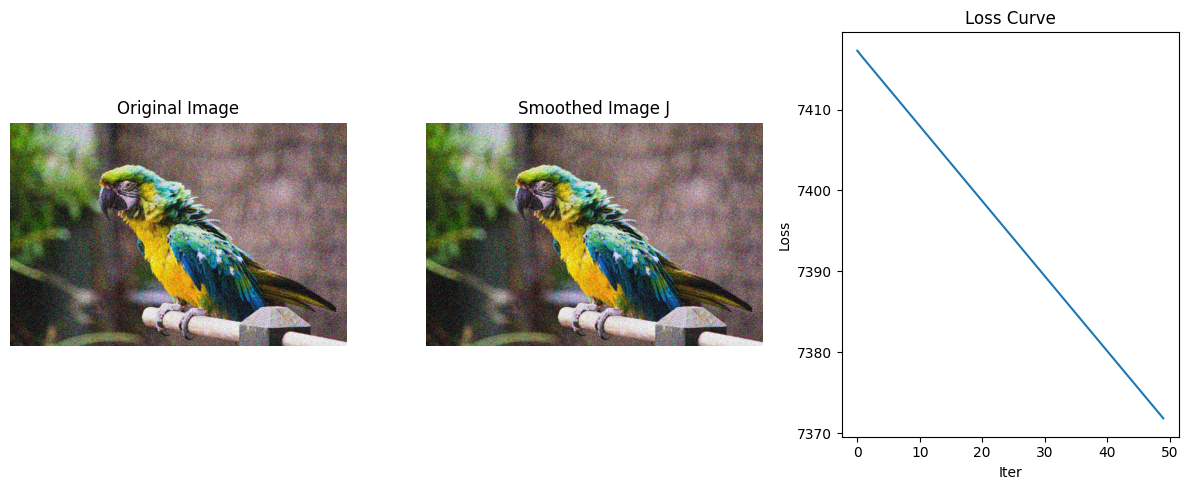

In [11]:
# 1.2c

def denoising_loss_L2(I, J, alpha):
  dxJ, dyJ = get_spatial_gradients(J)
  return torch.norm(I-J, p=2) + alpha*( torch.norm(dxJ, p=2) + torch.norm(dyJ, p=2))

I = torch.tensor(img, dtype=torch.float32)
I = I.to('cuda')

lr = 0.001 # Learning rate
alpha = 10.0 # alpha
n_iter = 50 # Number of iterations

# Initialize J to be a copy of I, with gradients
J = I.clone().detach().requires_grad_(True)
loss_log = [0]*n_iter
for i in range(n_iter):
  loss = denoising_loss_L2(I, J, alpha)
  loss_log[i] = loss.item()
  loss.backward()
  with torch.no_grad():
    J -= lr * J.grad
    J.grad.zero_()
# Detach and move result to CPU for plotting
J_img = J.detach().cpu().squeeze()

plt.figure(figsize=(12, 5))
# Original image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
# Smoothed image
plt.subplot(1, 3, 2)
plt.imshow(np.clip(J_img.numpy(), 0.0, 1.0), cmap='gray')
plt.title("Smoothed Image J")
plt.axis('off')
# Loss curve
plt.subplot(1, 3, 3)
plt.plot(loss_log)
plt.title("Loss Curve")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

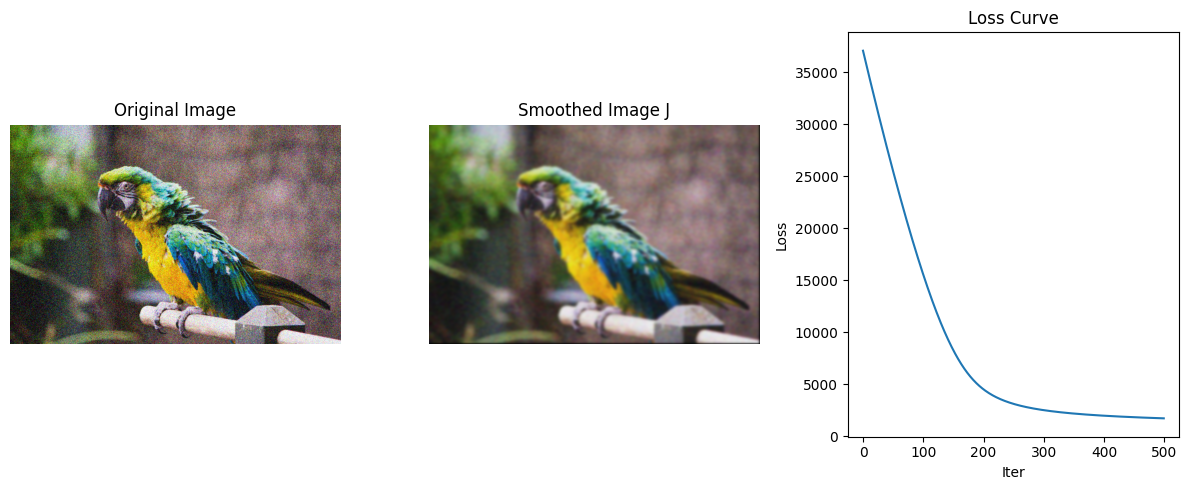

In [12]:
I = torch.tensor(img, dtype=torch.float32)
I = I.to('cuda')

lr = 0.01 # Learning rate
alpha = 50.0 # alpha
n_iter = 500 # Number of iterations

# Initialize J to be a copy of I, with gradients
J = I.clone().detach().requires_grad_(True)
loss_log = [0]*n_iter
for i in range(n_iter):
  loss = denoising_loss_L2(I, J, alpha)
  loss_log[i] = loss.item()
  loss.backward()
  with torch.no_grad():
    J -= lr * J.grad
    J.grad.zero_()
# Detach and move result to CPU for plotting
J_img = J.detach().cpu().squeeze()

plt.figure(figsize=(12, 5))
# Original image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
# Smoothed image
plt.subplot(1, 3, 2)
plt.imshow(np.clip(J_img.numpy(), 0.0, 1.0), cmap='gray')
plt.title("Smoothed Image J")
plt.axis('off')
# Loss curve
plt.subplot(1, 3, 3)
plt.plot(loss_log)
plt.title("Loss Curve")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

In my opinion, L2 is much worse. Basically, you can see that it did not work with the same hyperparameters as L1 (not that suprising), but the set of hyperparameters I found that worked 1) don't work that well and 2) are much slower to train (require many more iterations).

## Problem 2: Training an Image Classifier

### 2a: Finish implementing dataset class

In [13]:
class CIFARDataset(Dataset):
  def __init__(self, images, labels, mode, transform):
    self.transform = transform

    if mode == 'train':
      # Your code here. If training, use examples [0,40000) of the entire dataset
      self.images = images[0:40000]
      self.labels = labels[0:40000]

    elif mode == 'val':
      # Your code here. If validation, use examples [40,000-50,000) of the entire dataset
      self.images = images[40000:50000]
      self.labels = labels[40000:50000]

    elif mode == 'test':
      # Your code here. If testing, use examples [50,000-60,000) of the entire dataset
      self.images = images[50000:60000]
      self.labels = labels[50000:60000]

    else:
      raise ValueError('Invalid mode!')

  def __getitem__(self, idx):
    # Do the following:
    # 1. Get the image and label from the dataset corresponding to index idx.
    image = self.images[idx]
    label = self.labels[idx]
    # 2. Convert the label to a LongTensor (needs to be of this type because it
    # is an integer value and PyTorch will throw an error otherwise)
    label = torch.tensor(label, dtype=torch.long)
    # 3. Transform the image using self.transform. This will convert the image
    # into a tensor, scale it to [0,1], and apply data augmentations.
    if self.transform is not None:
        image = self.transform(image)
    # 4. Return the image and label.
    return image, label

  def __len__(self):
    return len(self.images)

### 2b: Write transforms

In [14]:
from torchvision.transforms import Compose, ToTensor, RandomHorizontalFlip, RandomAffine, ColorJitter

cifar = np.load('/content/drive/MyDrive/ELEC546/HW4/CIFAR.npz')
X, y, label_names = cifar['X'], cifar['y'] * 1.0, cifar['label_names']
print("Read in CIFAR10 dataset with %d examples, and labels:\n %s" % (X.shape[0], label_names))

batch_size = 64

transform = Compose([
    ToTensor(),
    RandomHorizontalFlip(),
    RandomAffine(degrees=5, scale=(0.8, 1.2)),
    ColorJitter(brightness=(0.8, 1.2), saturation=(0.8, 1.2))
])
train_dataset = CIFARDataset(X, y, "train", transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

transform = Compose([ToTensor()])
val_dataset = CIFARDataset(X, y, "val", transform)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

transform = Compose([ToTensor()])
test_dataset = CIFARDataset(X, y, "test", transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Read in CIFAR10 dataset with 60000 examples, and labels:
 ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


### 2c: Implement the model

In [15]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    # Have to use padding otherwise kernel_size is too big
    self.conv1 = nn.Conv2d(3, 50, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(100, 100, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(100, 100, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(100 * 4 * 4, 100)  # This is hardcoded in, but that's fine I think since the model isn't dynamic (can only be resized manually)
    self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = self.pool(x)

    x = F.relu(self.conv4(x))

    x = x.view(x.size(0), -1)  # Flatten to 2D, first dim is batchsize
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

### 2d/2e: Implement the training loop, and train your model.

In [16]:
# Your code here. Don't forget to call model.train() before training!

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import os

def train_model(model, train_dataset, val_dataset, save_dir, lr=1e-4, bs=64, num_epochs=15, device="cuda"):
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = nn.CrossEntropyLoss(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

        # Save checkpoint
        torch.save(model.state_dict(), os.path.join(save_dir, f'2e_model_epoch_{epoch+1}.pth'))

    return val_losses


In [17]:
# 2e

model = Model()
val_losses = train_model(model, train_dataset, val_dataset, save_dir='/content/drive/MyDrive/ELEC546/HW4/checkpoints')


Epoch 1/15
Epoch 1, Training Loss: 1211.9994
Epoch 1, Validation Loss: 1.6824
Epoch 2/15
Epoch 2, Training Loss: 1036.2959
Epoch 2, Validation Loss: 1.5716
Epoch 3/15
Epoch 3, Training Loss: 977.1165
Epoch 3, Validation Loss: 1.4788
Epoch 4/15
Epoch 4, Training Loss: 926.5071
Epoch 4, Validation Loss: 1.4196
Epoch 5/15
Epoch 5, Training Loss: 893.5568
Epoch 5, Validation Loss: 1.3551
Epoch 6/15
Epoch 6, Training Loss: 864.7985
Epoch 6, Validation Loss: 1.3188
Epoch 7/15
Epoch 7, Training Loss: 838.9036
Epoch 7, Validation Loss: 1.2916
Epoch 8/15
Epoch 8, Training Loss: 816.5537
Epoch 8, Validation Loss: 1.2708
Epoch 9/15
Epoch 9, Training Loss: 796.6165
Epoch 9, Validation Loss: 1.2073
Epoch 10/15
Epoch 10, Training Loss: 776.9299
Epoch 10, Validation Loss: 1.2488
Epoch 11/15
Epoch 11, Training Loss: 764.4876
Epoch 11, Validation Loss: 1.1524
Epoch 12/15
Epoch 12, Training Loss: 742.9187
Epoch 12, Validation Loss: 1.1524
Epoch 13/15
Epoch 13, Training Loss: 728.5534
Epoch 13, Validatio

### 2f: Choose the best model based on overall accuracy
using the validation dataset.

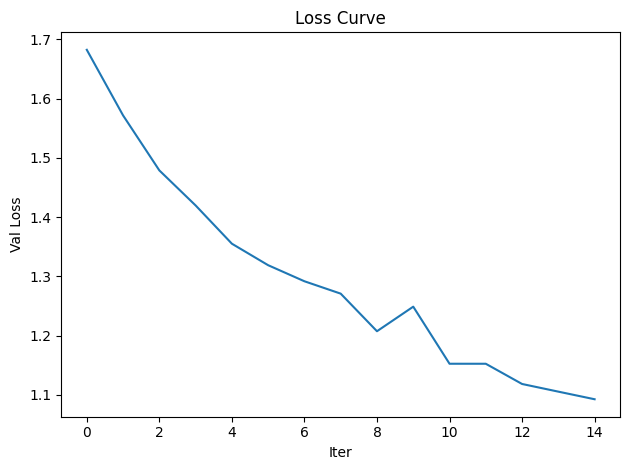

In [18]:
# I just eval the model inside the training loop since that's how I normally do it...
## So, just plotting the results here:

plt.figure()
plt.plot(val_losses)
plt.title("Loss Curve")
plt.xlabel("Iter")
plt.ylabel("Val Loss")
plt.tight_layout()
plt.show()

I choose the last model because it has the lowest validation loss. The model appears to not have overfit at all. The validation loss has not plateaued yet

### 2g: Implement code for computing overall accuracy, accuracy per class, and the confusion matrix on the test set.

In [19]:
# Your code here. Don't forget to call model.eval() first!

device = "cuda"
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Load in model 15
model = Model().to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/ELEC546/HW4/checkpoints/model_epoch_15.pth'))
model.eval()

# Calc overall accuracy
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
model.eval()
val_loss = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = nn.CrossEntropyLoss(outputs, labels)
        val_loss += loss.item()
avg_val_loss = val_loss / len(val_loader)
val_losses.append(avg_val_loss)

correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

overall_accuracy = correct / total
print(f"Overall accuracy: {overall_accuracy:.4f}")

# Calc accuracy per class
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
per_class_acc = []
for i in range(len(class_names)):
    correct_i = np.sum((all_preds == i) & (all_labels == i))
    total_i = np.sum(all_labels == i)
    acc_i = correct_i / total_i
    per_class_acc.append(acc_i)
    print(f"{class_names[i]} accuracy: {acc_i:.4f}")


# Create the confusion matrix (10x10)
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(all_labels, all_preds, normalize='true')
plt.figure()
sns.heatmap(conf_mat, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()

In [ ]:
# For the class with the worst accuracy, what class is it most often confused with? Show 5-10 test images and comment on similarities

# Find the class with worst accuracy
worst_class_idx = np.argmin(per_class_acc)
worst_class = class_names[worst_class_idx]
# Find the most confused class
confused_with_idx = np.argmax(conf_mat[worst_class_idx, :])
confused_with_class = class_names[confused_with_idx]
print(f"Worst performing class: {worst_class}")
print(f"Most confused with: {confused_with_class}")


In [ ]:
# Get indices of misclassified examples for this pair
misclassified_indices = np.where(
    (all_labels == worst_class_idx) & (all_preds == confused_with_idx)
)[0]

# Plot 5 of them
num_to_show = min(len(misclassified_indices), 5)
fig, axes = plt.subplots(1, num_to_show, figsize=(15, 2))
for i in range(num_to_show):
    idx = misclassified_indices[i]
    img, _ = test_dataset[idx]
    img = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"True: {worst_class}\nPred: {confused_with_class}")
    axes[i].axis('off')
plt.suptitle(f"{worst_class} misclassified as {confused_with_class}")
plt.show()


In [ ]:
# import libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Problem 3: Run Mask R-CNN with Detectron2

In [20]:
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).

import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15837 (delta 35), reused 14 (delta 14), pack-reused 15772 (from 2)
Receiving objects: 100% (15837/15837), 6.41 MiB | 9.84 MiB/s, done.
Resolving deltas: 100% (11533/11533), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.9 MB/s eta 0:00

In [21]:
# import libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [22]:
# load image
im = cv2.imread('/content/drive/My Drive/ELEC546/HW4/train.jpg')
cv2_imshow(im)

AttributeError: 'NoneType' object has no attribute 'clip'

In [ ]:
# Load pre-trained model
# You can find the model cofig from the following url, or other config of your choice
# https://github.com/facebookresearch/detectron2/tree/main/configs/COCO-Detection
# https://github.com/facebookresearch/detectron2/tree/main/configs/COCO-InstanceSegmentation

##### Your code #####
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("your choice of pretrained model"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Your choice of pretrained model")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST =   # set threshold for this model (0-1)

In [ ]:
# Create predictor
predictor = DefaultPredictor(cfg)
# Run inference on the sample image
outputs = predictor(im)

In [ ]:
# Visualize results with "Visualizer"
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Problem 4: Adversarial attacks for trained networks. Wite code below

In [ ]:
def fgsm_attack(model, image, eps):
  # Your code here.

In [ ]:
# Your code here for creating and displaying adversarial images.